# CLUB algorithm draft - Online Clustering of Bandits

In [103]:
import numpy as np
import numpy.random as npr
import numpy.linalg
import pandas as pd
from scipy.spatial.distance import euclidean
import networkx as nx
import matplotlib.pyplot as plt

### Commentaires

Quelques remarques pour la partie Artificial Datasets page 6:
   
* Vecteurs des vrais clusters $u_{j}$ est crée directement. Pas besoin de M et b
* Matrices C générées sur la sphere unitaire, on aurait alors un nombre infini de profils de users mais pas trop distants les uns des autres (je l'ai déjà intégré dans le code avec la fonction sphere_unif)
* T = 5000 + 50,000 pourquoi cette décomposition ?

Problème de convergence: sur une période suffisamment longue, on supprime tous les noeuds du graphe <br>

# Initialisation

In [48]:
#tests
V=nx.Graph()
V.add_node(1)
V.add_node(2)
V.add_node(3)
V.add_edge(1,2)
V.add_edge(3,2)
print(V.adj)

{1: {2: {}}, 2: {1: {}, 3: {}}, 3: {2: {}}}


In [169]:
V=nx.Graph(np.ones([4,4]))
#V=nx.Graph(np.identity(3))
#print(V.adj)
print(V[1])

{0: {'weight': 1.0}, 1: {'weight': 1.0}, 2: {'weight': 1.0}, 3: {'weight': 1.0}}


In [166]:
V.remove_edge(0,1)
V.remove_edge(2,3)
V.remove_edge(3,1)
V.remove_edge(0,2)

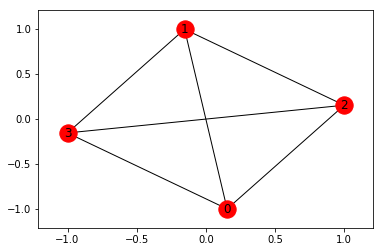

In [170]:
nx.draw_networkx(V)
plt.show()

In [171]:
len(list(nx.connected_component_subgraphs(V)))

1

In [118]:
list(V.nodes)

[0, 1, 2]

In [121]:
V[0][2]

{'weight': 1.0}

In [119]:
[n for n in V[1]]

[1, 2]

In [95]:
0 in V[1]

True

In [117]:
V.remove_edge(0,1)

In [106]:
#sphere unitaire pour générer les matrices de contexte C à chaque période
def sphere_unif(dim,N):
    norm = np.random.normal
    normal_deviates = norm(size=(dim, N))
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius
    return(points)

In [176]:
#itérations
T=10
#nombre d'utilisateurs
n_user=27
#dimension des catégories/labels à prédire
D=3
#matrice M_i associée à l'approximation des paramètres du cluster j(i)
#paramètre b_i associé à l'approximation des paramètres du cluster j(i)
d_M=dict()
d_b=dict()
for i in range(n_user):
    d_M['M%d' % i]=np.identity(D)
    d_b['b%d' % i]=np.zeros(D)

#vrai nombre de clusters (supposé connu et constant pour chaque période) 
m=3
#nombre de clusters estimé. Pas nécessaire dans l'algo ? On part de c=1, un seul cluster à t=0
c=1         
#variation autour de la payoff (white noise)
sigma=1
#nombre de users dans chaque cluster

#initialiser omega
omega=np.ones(D)
#init matrice V du graphe réel
V=nx.Graph( np.ones([n_user,n_user]) )
#paramètre du confidence bound
alpha=1
alpha2=1
#standard deviation du white noise
sigma=1
#liste des indices précédents
list_i=[]
#liste de matrices de contexte C_it pré-définies. Pour user i à période t, on va piocher dans cette liste
#nb_context=int(n_user/3) #nombre de contextes différents
#list_C=[]
#for cont in range(nb_context):
#    list_C.append(npr.uniform(0,1,size=[D,c]))
    #list_C.append(npr.normal(0,1,size=[D,c]))


## Algo CLUB

période t= 0
user i= 9
omega: [ 0.  0.  0.]


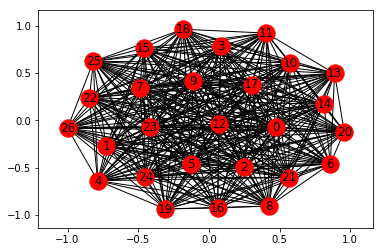

période t= 1
user i= 13
omega: [ 0.  0.  0.]


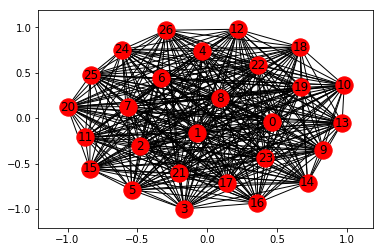

période t= 2
user i= 7
omega: [ 0.  0.  0.]


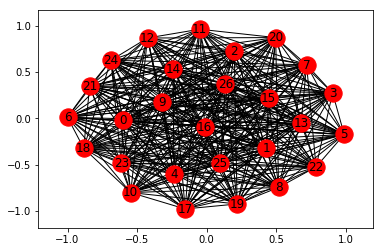

période t= 3
user i= 8
omega: [ 0.  0.  0.]


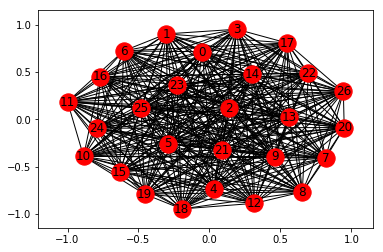

période t= 4
user i= 17
omega: [ 0.  0.  0.]


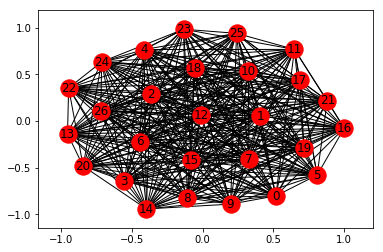

période t= 5
user i= 11
omega: [ 0.  0.  0.]


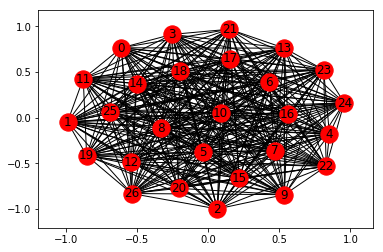

période t= 6
user i= 22
omega: [ 0.  0.  0.]


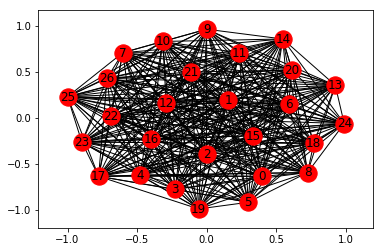

période t= 7
user i= 15
omega: [ 0.  0.  0.]


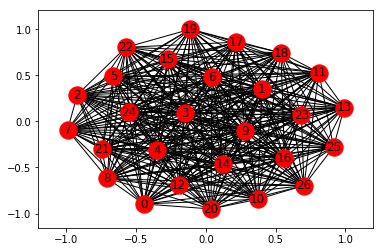

période t= 8
user i= 17
omega: [ 0.46901194 -0.10218244 -0.38748226]
brise le lien entre users 17 et 22


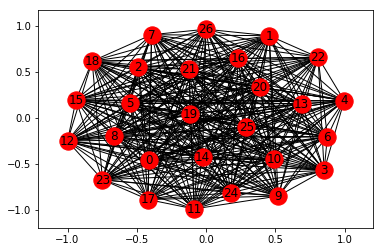

période t= 9
user i= 8
omega: [-0.39771159 -0.02799979  0.29950293]
brise le lien entre users 8 et 9
brise le lien entre users 8 et 13
brise le lien entre users 8 et 17


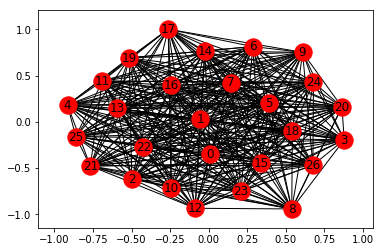

période t= 10
user i= 18
omega: [ 0.  0.  0.]
brise le lien entre users 18 et 19
brise le lien entre users 18 et 20
brise le lien entre users 18 et 21
brise le lien entre users 18 et 23
brise le lien entre users 18 et 24
brise le lien entre users 18 et 25
brise le lien entre users 18 et 26


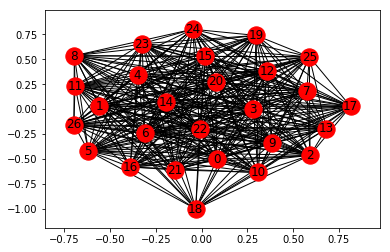

période t= 11
user i= 10
omega: [ 0.  0.  0.]
brise le lien entre users 10 et 17
brise le lien entre users 10 et 18


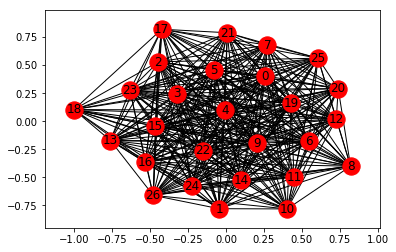

période t= 12
user i= 9
omega: [ 0.17227133 -0.07237651 -0.19398289]
brise le lien entre users 9 et 18


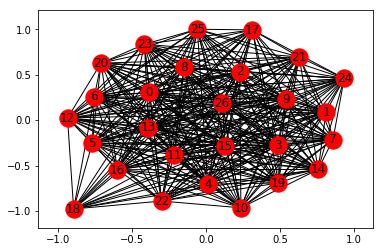

période t= 13
user i= 23
omega: [ 0.  0.  0.]
brise le lien entre users 23 et 24
brise le lien entre users 23 et 25
brise le lien entre users 23 et 26


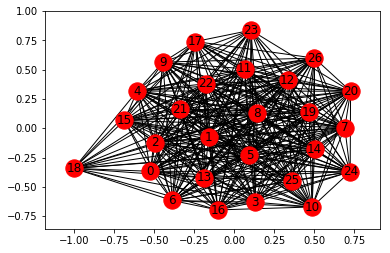

période t= 14
user i= 13
omega: [ 0.20408288 -0.3913989   0.36147209]
brise le lien entre users 13 et 18


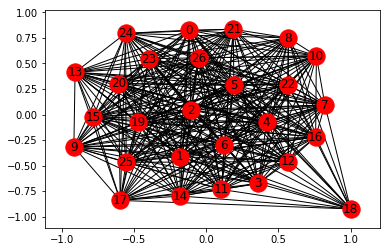

période t= 15
user i= 2
omega: [ 0.  0.  0.]
brise le lien entre users 2 et 3
brise le lien entre users 2 et 4
brise le lien entre users 2 et 5
brise le lien entre users 2 et 6
brise le lien entre users 2 et 7
brise le lien entre users 2 et 8
brise le lien entre users 2 et 9
brise le lien entre users 2 et 10
brise le lien entre users 2 et 11
brise le lien entre users 2 et 12
brise le lien entre users 2 et 13
brise le lien entre users 2 et 14
brise le lien entre users 2 et 15
brise le lien entre users 2 et 16
brise le lien entre users 2 et 17
brise le lien entre users 2 et 18
brise le lien entre users 2 et 19
brise le lien entre users 2 et 20
brise le lien entre users 2 et 21
brise le lien entre users 2 et 22
brise le lien entre users 2 et 23
brise le lien entre users 2 et 24
brise le lien entre users 2 et 25
brise le lien entre users 2 et 26


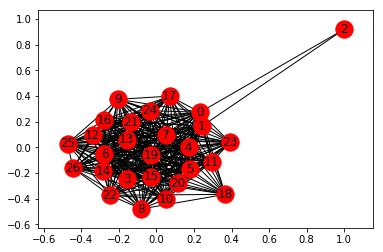

période t= 16
user i= 2
omega: [ 0.60860692 -6.55020349  5.45010388]
brise le lien entre users 2 et 0
brise le lien entre users 2 et 1


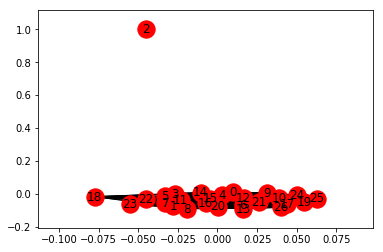

période t= 17
user i= 7
omega: [ 0.02392965 -0.42238821  0.68743477]
brise le lien entre users 7 et 8
brise le lien entre users 7 et 10
brise le lien entre users 7 et 18


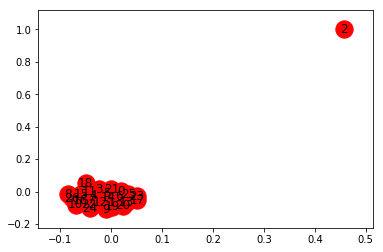

période t= 18
user i= 6
omega: [ 0.  0.  0.]
brise le lien entre users 6 et 7
brise le lien entre users 6 et 8
brise le lien entre users 6 et 9
brise le lien entre users 6 et 10
brise le lien entre users 6 et 11
brise le lien entre users 6 et 12
brise le lien entre users 6 et 13
brise le lien entre users 6 et 14
brise le lien entre users 6 et 15
brise le lien entre users 6 et 16
brise le lien entre users 6 et 17
brise le lien entre users 6 et 18
brise le lien entre users 6 et 19
brise le lien entre users 6 et 20
brise le lien entre users 6 et 21
brise le lien entre users 6 et 22
brise le lien entre users 6 et 23
brise le lien entre users 6 et 24
brise le lien entre users 6 et 25
brise le lien entre users 6 et 26


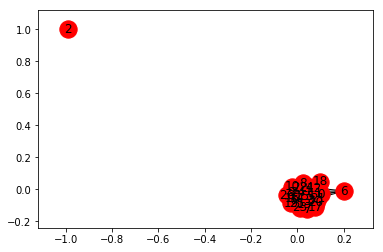

période t= 19
user i= 4
omega: [ 0.  0.  0.]
brise le lien entre users 4 et 5
brise le lien entre users 4 et 8
brise le lien entre users 4 et 9
brise le lien entre users 4 et 10
brise le lien entre users 4 et 11
brise le lien entre users 4 et 12
brise le lien entre users 4 et 13
brise le lien entre users 4 et 14
brise le lien entre users 4 et 15
brise le lien entre users 4 et 16
brise le lien entre users 4 et 18
brise le lien entre users 4 et 19
brise le lien entre users 4 et 20
brise le lien entre users 4 et 21
brise le lien entre users 4 et 22
brise le lien entre users 4 et 24
brise le lien entre users 4 et 25
brise le lien entre users 4 et 26


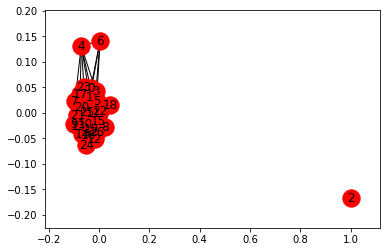

période t= 20
user i= 21
omega: [ 0.  0.  0.]
brise le lien entre users 21 et 23
brise le lien entre users 21 et 24
brise le lien entre users 21 et 25
brise le lien entre users 21 et 26


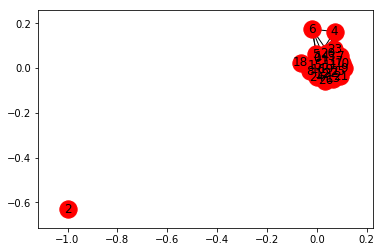

période t= 21
user i= 11
omega: [-0.05095736 -0.00237674  0.04978294]
brise le lien entre users 11 et 12
brise le lien entre users 11 et 13
brise le lien entre users 11 et 14
brise le lien entre users 11 et 15
brise le lien entre users 11 et 16
brise le lien entre users 11 et 17
brise le lien entre users 11 et 18
brise le lien entre users 11 et 19
brise le lien entre users 11 et 20
brise le lien entre users 11 et 21
brise le lien entre users 11 et 22
brise le lien entre users 11 et 23
brise le lien entre users 11 et 24
brise le lien entre users 11 et 25
brise le lien entre users 11 et 26


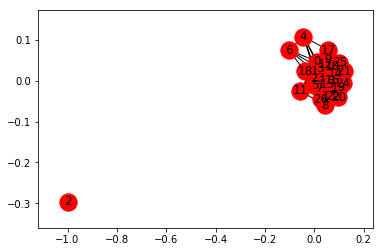

période t= 22
user i= 24
omega: [ 0.  0.  0.]


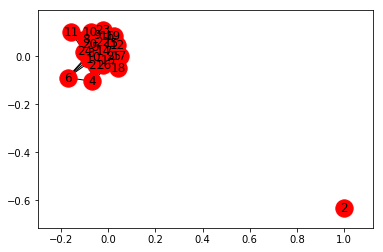

période t= 23
user i= 19
omega: [ 0.  0.  0.]
brise le lien entre users 19 et 20
brise le lien entre users 19 et 21
brise le lien entre users 19 et 22
brise le lien entre users 19 et 24
brise le lien entre users 19 et 25
brise le lien entre users 19 et 26


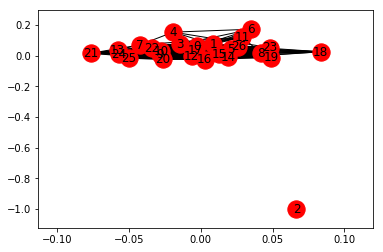

période t= 24
user i= 7
omega: [ 0.40437911 -1.11163872  0.72075458]
brise le lien entre users 7 et 4
brise le lien entre users 7 et 9
brise le lien entre users 7 et 11
brise le lien entre users 7 et 12
brise le lien entre users 7 et 13
brise le lien entre users 7 et 14
brise le lien entre users 7 et 15
brise le lien entre users 7 et 16
brise le lien entre users 7 et 17
brise le lien entre users 7 et 19
brise le lien entre users 7 et 20
brise le lien entre users 7 et 21
brise le lien entre users 7 et 22
brise le lien entre users 7 et 23
brise le lien entre users 7 et 24
brise le lien entre users 7 et 25
brise le lien entre users 7 et 26


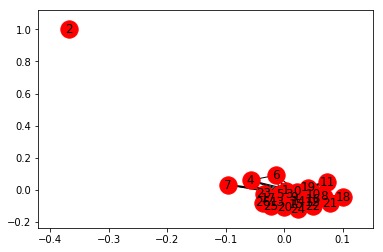

In [177]:
T=25
for t in range(T):
    print("période t=",t)
    #choisir aléatoirement un user i
    i=int(npr.uniform(0,n_user))
    print("user i=",i)
    list_i.append(i)
    #reçoit contexte C_it généré aléatoirement sur une sphere unitaire
    C = sphere_unif(D,c)
    #piocher dans un ensemble de profils générés aléatoirement à t=0
    #indique les préférences de user i à période t pour chaque cluster estimé 1...c
    #C = list_C[ int( npr.uniform(0,nb_context) ) ]  
    #genère omega
    omega=np.zeros([n_user,D])
    print("omega:",np.dot(np.linalg.inv(d_M['M'+str(int(i))]),d_b['b'+str(int(i))]))
    omega[i,:]=np.dot(np.linalg.inv(d_M['M'+str(int(i))]),d_b['b'+str(int(i))])
    #détermine l'indice du cluster de i: j_t(i)
    #calcule M_bar et b_bar et omega aggrégés
    #on récupère tous les indices qui appartiennent au même cluster que celui de i
    M_index = [ n for n in V[i] ]  #liste d'indices des noeuds au point i
    M_sum=sum([d_M['M'+str(int(k))] for k in M_index])
    M_bar=np.identity(D)+M_sum-len(M_index)*np.identity(D)
    b_bar=sum([d_b['b'+str(int(k))] for k in M_index])
    omega_bar=np.dot(np.linalg.inv(M_bar),b_bar)
    #détermine k_t optimal pour cluster j_t(i)
    vect_k=np.zeros(c)
    for k in range(c):
        CB=alpha*np.sqrt(np.dot(np.dot(C[:,k].T,np.linalg.inv(M_bar)),C[:,k])*np.log(t+1))
        vect_k[k]=CB+np.dot(omega_bar.T,C[:,k])
    k_t=[v for v in range(c) if vect_k[v]==np.max(vect_k)][0]
    #calcule payoffs
    a_t=np.dot(omega_bar,C[:,k_t])+npr.normal(loc=0,scale=sigma,size=1)
    #update weights
    d_M['M'+str(int(i))]=d_M['M'+str(int(i))]+np.dot(C[:,k_t],C[:,k_t].T)
    d_b['b'+str(int(i))]=d_b['b'+str(int(i))]+a_t*C[:,k_t]
    #update clusters
    T_i=list_i.count(i)-1  #nombre de user i piochés sur les périodes précédentes (exlcue période t actuelle)
    if list_i.count(i)==1: #cas spécifique pour lorsque i est pioché pour la 1ère fois
        T_i=1
    CB_tild=np.zeros(n_user) #calcul des bornes de confiance pour tous les user
    CB_tild[i]=alpha2*np.sqrt((1+np.log(1+T_i))/(1+T_i)) #CB pour i, on en a besoin dans la boucle sur les autres users
    for l in range(n_user): #CB pour les autres users
        T_i=list_i.count(l)-1
        if list_i.count(l)==1:
            T_i=1
        if list_i.count(l)==0:
            T_i=0
        CB_tild[l]=alpha2*np.sqrt((1+np.log(1+T_i))/(1+T_i))
        omega[l,:]=np.dot(np.linalg.inv(d_M['M'+str(int(l))]),d_b['b'+str(int(l))])
        norm_diff_omega=euclidean(omega[l,:],omega[i,:])
        if (norm_diff_omega > CB_tild[l] + CB_tild[i]) & (l in V[i]): #si la distance entre users i et l on brise le lien
            V.remove_edge(i,l)
            print("brise le lien entre users",i,"et",l)
        #update le nombre de sous-graphes i.e. # de clusters
        c=len( list( nx.connected_component_subgraphs(V) ) )
    nx.draw_networkx(V)
    plt.show()
    
